# Predicción con el dataset [titanic](https://www.kaggle.com/c/titanic/)

> El hundimiento del Titanic es una de las tragedias marítimas más conocidas de la historia. El 15 de abril de 1912, durante su viaje inaugural, el Titanic se hundió después de chocar contra un iceberg. En el accidente murieron 1502 personas de las 2224 que habían embarcado, incluyendo pasajeros y tripulación. Una de las razones por las que no se encontraron más supervivientes fue la falta de espacio en los barcos salvavidas. Así, aunque la suerte sin duda sonrió a los supervivientes, también resultaron más favorecidos algunos grupos de personas...

**En este ejercicio analizaremos qué tipos de personas tuvieron más probabilidades de sobrevivir. Para ello, aplicaremos técnicas de aprendizaje automático que nos permitirán predecir qué pasajeros sobrevivieron al hundimiento.**

En este cuaderno vamos a estudiar la creación y evaluación de modelos de clasificación con redes neuronales usando [`scikit-learn`](https://scikit-learn.org/stable/), [`Keras`](https://keras.io/) y [`PyTorch`](https://pytorch.org/).

Utilizaremos datos de la competición de Kaggle sobre el [*Titanic*](https://www.kaggle.com/c/titanic/).  Kaggle es una plataforma en línea que organiza competiciones de ciencia de datos y aprendizaje automático. Los participantes pueden acceder a conjuntos de datos reales, desarrollar modelos predictivos y competir por premios.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Carga y preprocesamiento de datos

Para la lectura de datos, utilizaremos la biblioteca [`pandas`](https://pandas.pydata.org/).

In [2]:
data_raw = pd.read_csv('train.csv')
data_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Seleccionar columnas y crear copia
data = data_raw[['Survived', 'Pclass', 'Sex', 'Age']].copy()

# Recodificar 'Fare'
fare_bins = [0, 10, 20, 30, float('inf')]
fare_labels = ['<10', '10-20', '20-30', '30+']
data['Fare_Interval'] = pd.cut(data_raw['Fare'], bins=fare_bins, labels=fare_labels, right=False)

# Eliminar filas con valores perdidos
data.dropna(inplace=True)

data

,Survived,Pclass,Sex,Age,Fare_Interval
0,0,3,male,22.0,<10
1,1,1,female,38.0,30+
2,1,3,female,26.0,<10
3,1,1,female,35.0,30+
4,0,3,male,35.0,<10
...,...,...,...,...,...
885,0,3,female,39.0,20-30
886,0,2,male,27.0,10-20
887,1,1,female,19.0,30+
889,1,1,male,26.0,30+


Binarizar variables categóricas y crear particiones de entrenamiento y test:

In [4]:
X = pd.get_dummies(data[['Pclass', 'Sex', 'Fare_Interval']])
X = X.assign(Age=data['Age'])
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
X_train.head()

,Pclass,Sex_female,Sex_male,Fare_Interval_<10,Fare_Interval_10-20,Fare_Interval_20-30,Fare_Interval_30+,Age
387,2,True,False,False,True,False,False,36.0
685,2,False,True,False,False,False,True,25.0
20,2,False,True,False,False,True,False,35.0
331,1,False,True,False,False,True,False,45.5
396,3,True,False,True,False,False,False,31.0


In [6]:
y_train.head()

,Survived
387,1
685,0
20,0
331,0
396,0


## Redes neuronales con [`scikit-learn`](https://scikit-learn.org/stable/)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

Entrenamiento:

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), random_state=0)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10), random_state=0)

A continuación, podemos visualizar los valores de la función de pérdida durante el entrenamiento del modelo. Puede usarse también parámetro `verbose=True` en la creación del [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

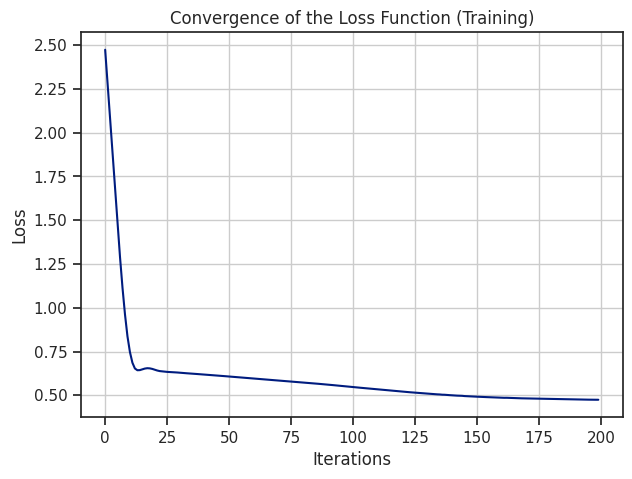

In [9]:
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks", palette="dark")
sns.lineplot(data=mlp.loss_curve_)
plt.title('Convergence of the Loss Function (Training)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Veamos como se comporta esta red neuronal que acabamos de entrenar sobre el dataset de `test`:

In [10]:
y_test_pred = mlp.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(classification_report(y_test, y_test_pred))

y_test_pred_proba = mlp.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Test ROC AUC: {test_roc_auc:.2f}")

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        79
           1       0.80      0.75      0.77        64

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143

Test ROC AUC: 0.87


Dado que las redes neuronales tienen varios hiperparámetros (tamaño de las capas, función de activación, alpha, tasa de aprendizaje...) que pueden ajustarse, intentaremos encontrar los mejores valores de forma automática. Para ello, podemos usar [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que nos permite realizar distintas combinaciones de hiperparámetros. [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) realiza internamente cross-validation, por lo que así nos aseguramos de que los resultados son robustos.

In [11]:
param_grid = {
    'hidden_layer_sizes': [(10, 10), (20, 20), (30, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(estimator=MLPClassifier(max_iter=1000, random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validated score:  {:.2f}".format(grid_search.best_score_))

Best parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validated score:  0.81


Y finalmente obtenemos, usando el dataset de `test`, los resultados con mejor modelo encontrado:

Test Accuracy (Neural Network): 0.82


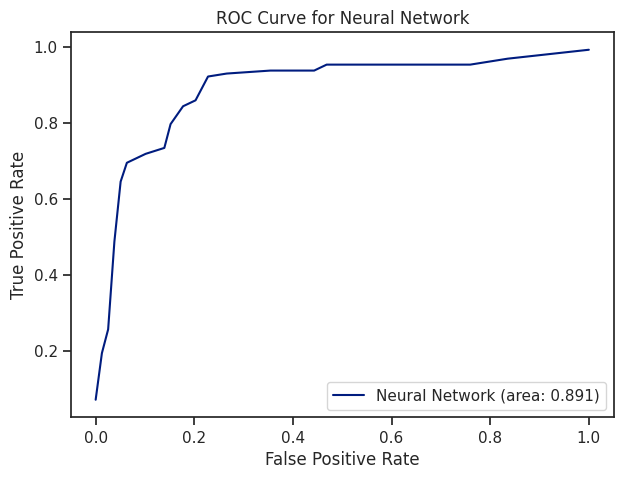

In [12]:
best_mlp_model = grid_search.best_estimator_

y_test_pred_nn = best_mlp_model.predict(X_test)
test_accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
print(f"Test Accuracy (Neural Network): {test_accuracy_nn:.2f}")

y_test_pred_proba_nn = best_mlp_model.predict_proba(X_test)[:, 1]
test_roc_auc_nn = roc_auc_score(y_test, y_test_pred_proba_nn)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_pred_proba_nn)

plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks", palette="dark")
sns.lineplot(x=fpr_nn, y=tpr_nn, label=f'Neural Network (area: {test_roc_auc_nn:.3f})', errorbar=None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend(loc='lower right')
plt.show()

## Redes neuronales con [`Keras`](https://keras.io/)

[`Keras`](https://keras.io/) ya está disponible en Google Colab.

Para la instalación de en local, utilizaremos:

```pip install tensorflow```

Hay que tener en cuenta que puede haber problemas en OS X y, tanto en esta como en otras plataformas, dificultados para configurar el soporte de GPU.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers, models
print(f"Keras version: {keras.__version__}")

Keras version: 3.8.0


Definición de la arquitectura de la red:

<img src="nn-ffn.png" width="400"/> (imagen generada con https://alexlenail.me/NN-SVG/)


In [23]:
mlp_keras = models.Sequential([
  layers.Dense(10, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

Configurar entrenamiento (_compilación_):

In [24]:
mlp_keras.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["accuracy"]
)

Entrenamiento:

In [25]:
history = mlp_keras.fit(
  X_train,
  y_train,
  epochs=10,
  batch_size=128,
  validation_split=0.2
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5354 - loss: 0.2570 - val_accuracy: 0.5043 - val_loss: 0.2762
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5291 - loss: 0.2561 - val_accuracy: 0.5043 - val_loss: 0.2741
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5389 - loss: 0.2508 - val_accuracy: 0.5217 - val_loss: 0.2715
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5350 - loss: 0.2528 - val_accuracy: 0.5478 - val_loss: 0.2682
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5543 - loss: 0.2490 - val_accuracy: 0.5652 - val_loss: 0.2658
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5917 - loss: 0.2452 - val_accuracy: 0.5826 - val_loss: 0.2631
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5765 - loss: 0.2492 - val_accuracy: 0.5826 - val_loss: 0.2595
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5980 - loss: 0.2359 - val_accuracy: 0.5826 - val_loss: 0.2568

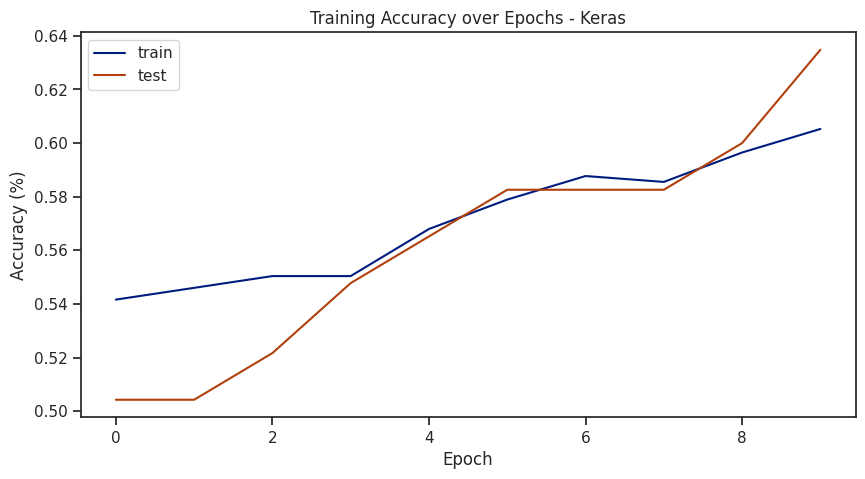

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy over Epochs - Keras')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

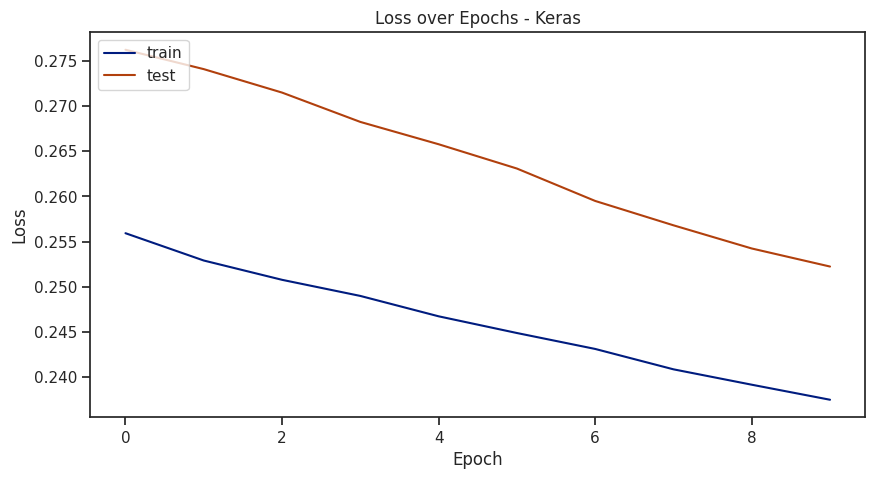

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over Epochs - Keras')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test:

In [28]:
test_loss, test_accuracy = mlp_keras.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.6364


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


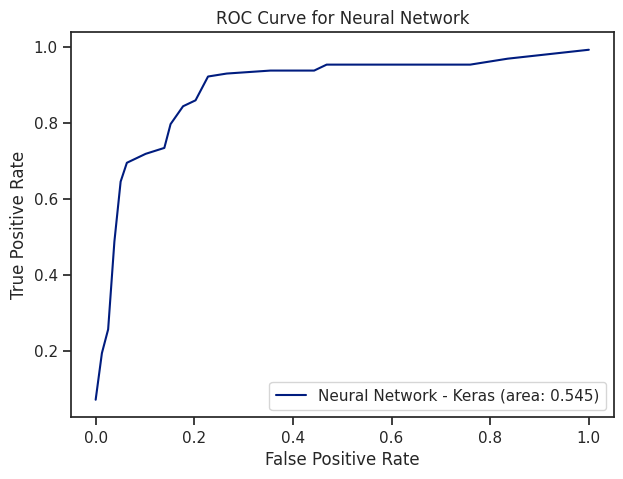

In [29]:
y_test_pred_nn_keras = mlp_keras.predict(X_test)

test_roc_auc_nn_keras = roc_auc_score(y_test, y_test_pred_nn_keras)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_nn_keras)

plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks", palette="dark")
sns.lineplot(x=fpr_nn, y=tpr_nn, label=f'Neural Network - Keras (area: {test_roc_auc_nn_keras:.3f})', errorbar=None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend(loc='lower right')
plt.show()


Mostrar arquitectura:

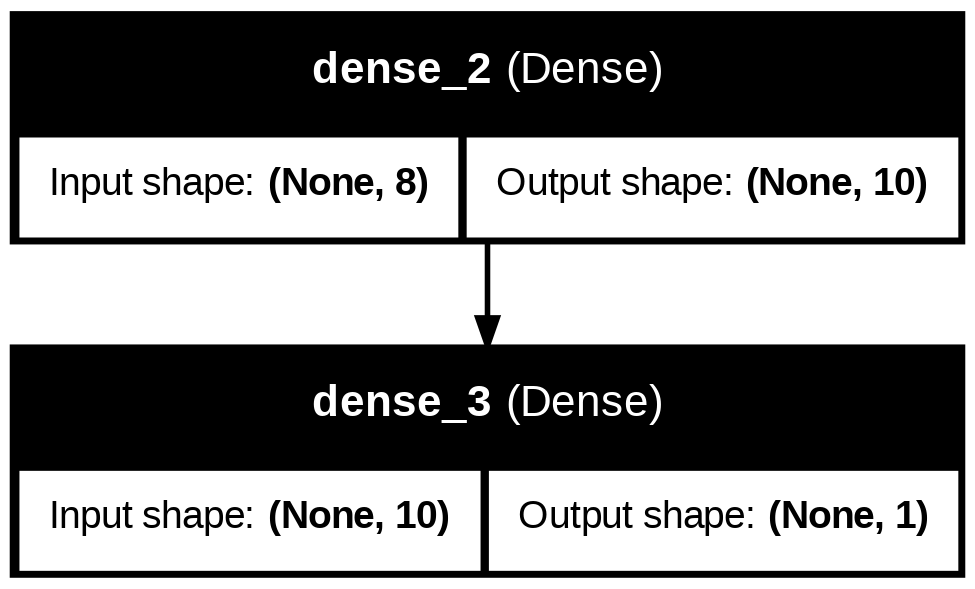

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(mlp_keras, to_file='mlp_keras_model.png', show_shapes=True, show_layer_names=True)


## Redes neuronales con [`PyTorch`](https://pytorch.org/)

 [`PyTorch`](https://pytorch.org/) ya está disponible en Google Colab.

Para la instalación de en local, utilizaremos:

```pip install torch```

Hay que tener en cuenta que puede haber problemas en OS X y, tanto en esta como en otras plataformas, dificultados para configurar el soporte de GPU.

In [31]:
import torch
import torch.nn as nn
import torch.optim
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.5.1+cu124


Definición de la arquitectura de la red:

In [32]:
mlp_torch = nn.Sequential(
    nn.Linear(in_features = X_train.shape[1], out_features = 10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
    nn.Sigmoid()
)
mlp_torch = mlp_torch.to(device)

mlp_torch

Sequential(
  (0): Linear(in_features=8, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)

Configurar entrenamiento:

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_torch.parameters(), lr=0.001)

Preparar datos:

In [34]:
x_dataset = torch.tensor(X_train.to_numpy(dtype=np.float32), dtype=torch.float32)
y_dataset = torch.tensor(y_train.to_numpy(dtype=np.int64), dtype=torch.float32)
train_dataset   = torch.utils.data.TensorDataset(x_dataset, y_dataset)

Entrenamiento:

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

num_epochs = 10
batch_size = 128
accuracy_list = []

for epoch in range(1, num_epochs+1):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for (i, data) in enumerate(train_loader, 0):
        x, y = data

        x = x.to(device)            # Enviar al dispositivo (GPU)
        y = y.to(device)

        optimizer.zero_grad()       # Resetear gradientes

        y_hat = mlp_torch(x)        # Calcular salida
        loss = criterion(y_hat, y)  # Calcular función de pérdida
        loss.backward()             # Retropropagación del error
        optimizer.step()            # Optimizar pesos

        epoch_loss += loss.item()   # Agregar error de esta epoch

        # Calcular número de aciertos (umbral: 0.5)
        predicted = (y_hat > 0.5).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()

    accuracy = correct / total / 100
    accuracy_list.append(accuracy)  # Almacenar para mostrar posteriormente

    print("Epoch [%4d/%4d], epoch loss: %.4f, accuracy: %.4f" % (epoch, num_epochs, float(epoch_loss) / batch_size, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [   1/  10], epoch loss: 0.0142, accuracy: 0.7359
Epoch [   2/  10], epoch loss: 0.0135, accuracy: 0.7299
Epoch [   3/  10], epoch loss: 0.0130, accuracy: 0.7266
Epoch [   4/  10], epoch loss: 0.0124, accuracy: 0.7267
Epoch [   5/  10], epoch loss: 0.0118, accuracy: 0.7287
Epoch [   6/  10], epoch loss: 0.0109, accuracy: 0.7288
Epoch [   7/  10], epoch loss: 0.0101, accuracy: 0.7266
Epoch [   8/  10], epoch loss: 0.0097, accuracy: 0.6978
Epoch [   9/  10], epoch loss: 0.0097, accuracy: 0.6204
Epoch [  10/  10], epoch loss: 0.0098, accuracy: 0.5972


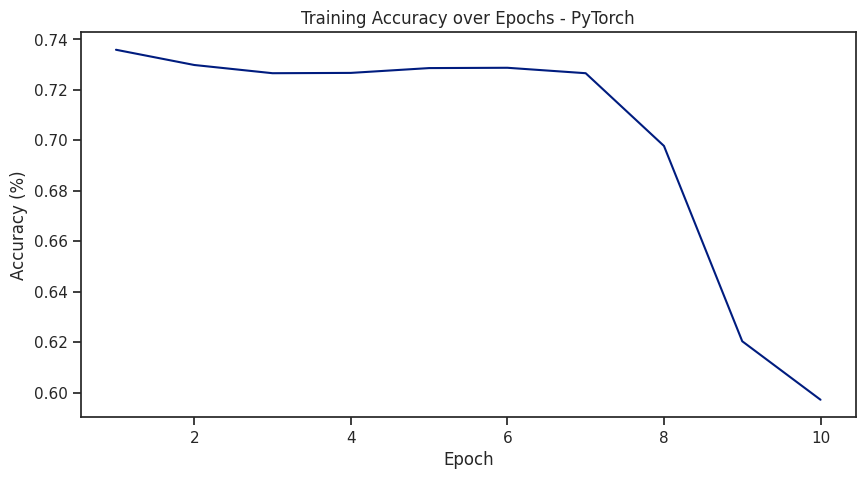

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.title('Training Accuracy over Epochs - PyTorch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()


Test:

In [37]:
x_dataset = torch.tensor(X_test.to_numpy(dtype=np.float32), dtype=torch.float32)
y_dataset = torch.tensor(y_test.to_numpy(dtype=np.int64), dtype=torch.float32)
test_dataset   = torch.utils.data.TensorDataset(x_dataset, y_dataset)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

with torch.no_grad():        # No calcular gradientes, solo paso hacia adelante
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        y_hat = mlp_torch(x)
        predicted = (y_hat > 0.5).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()

    print(f'Test accuracy: {(correct / total / 100):.4f}')

Test accuracy: 0.6119
